# ML Algorithms

The purpose of this notebook is to apply ML algorithms to the reduced dimensionality dataset calculated in notebook 02. Three algorithms are chosen:

- Logistic Regression

- Random Forests

- XGBoost

Each of these algorithms will undergo hyperparameter tunings to achieve maximum performance. The predictions, training and final model feature importance will be assessed.

# Table of Contents <a id = 'ToC'></a>

- Prepare data [1](#prepare)

- Logistic Regression [2](#lr)

- Random Forests [3](#rf)

- XGBoost [4](#xgb)

In [4]:
import numpy as np
import pandas as pd
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data [Return](#ToC) <a id = 'prepare'></a>

In [5]:
data = pd.read_csv('../data/fake_news_features.csv')
feature_columns = load('../param_store/selected_columns.joblib')

X = data.drop('label', axis = 1)
y = data['label']

X = X[feature_columns]

In [6]:
labels = X.columns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [8]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [31]:
def display_results(truth, predictions, pred_proba):
    print('Confusion matrix results:')
    print(confusion_matrix(truth, predictions))
    tn, fp, fn, tp = confusion_matrix(truth, predictions).ravel()
    print(f'Accuracy: {(tp + tn) / (tp + tn + fn + fp)}')
    prec = (tp) / (tp + fp)
    rec = (tp) / (tp + fn)
    print(f'Recall: {rec}')
    print(f'Precision: {prec}')
    print(f'F1: {2 * prec * rec / (prec + rec)}')
    tpr, fpr, thresh = roc_curve(truth, pred_proba)
    sns.regplot(tpr, fpr, fit_reg = False)
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    return

In [28]:
def plot_CV_scores(cv_obj):
    f, axes = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(15)

    for i in np.arange(4):
        sns.lineplot(x = np.arange(len(cv_obj.cv_results_['split'+str(i)+'_train_score'])), 
                 y = cv_obj.cv_results_['split'+str(i)+'_train_score'], ax = axes[0])
    sns.lineplot(x = np.arange(len(cv_obj.cv_results_['mean_train_score'])), 
                 y = cv_obj.cv_results_['mean_train_score'], color =  'k', ax = axes[0], label = 'average')
    axes[0].set_xlabel('hyperparameter combination')
    axes[0].set_ylabel('model score')
    axes[0].set_title('Training data')
    
    for i in np.arange(4):
        sns.lineplot(x = np.arange(len(cv_obj.cv_results_['split'+str(i)+'_test_score'])), 
                 y = cv_obj.cv_results_['split'+str(i)+'_test_score'], ax = axes[1])
    sns.lineplot(x = np.arange(len(cv_obj.cv_results_['mean_test_score'])), 
                 y = cv_obj.cv_results_['mean_test_score'], color =  'k', ax = axes[1], label = 'average')
    axes[1].set_xlabel('hyperparameter combination')
    axes[1].set_ylabel('model score')
    axes[1].set_title('Hold out data')

In [22]:
def plot_importance(labels, weights):
    coefficients = pd.DataFrame(zip(labels, weights), columns = ['Feature', 'Weight'])
    coefficients.sort_values(by = 'Weight', inplace = True)
    f, axes = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(13)
    sns.barplot(x = 'Feature', y = 'Weight', data = coefficients.iloc[:5, :], ax = axes[0])
    axes[0].tick_params(labelrotation=90, axis = 'x')
    axes[0].set_title('Least important features')

    sns.barplot(x = 'Feature', y = 'Weight', data = coefficients.iloc[-5:, :], ax = axes[1])
    axes[1].tick_params(labelrotation=90, axis = 'x')
    axes[1].set_title('Most important features')
    plt.tight_layout()
    plt.show()

# Logistic Regression [Return](#ToC) <a id = 'lr'></a>

Best hyperparameters:
{'C': 0.1}
Confusion matrix results
[[1947  131]
 [ 145 1930]]
Accuracy: 0.9335420178184445
Recall: 0.9301204819277108
Precision: 0.9364386220281417
F1: 0.9332688588007737


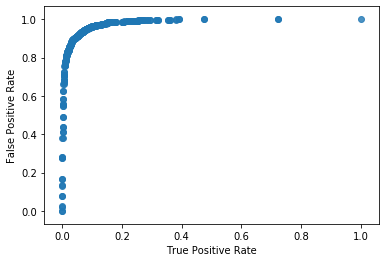

In [30]:
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100, 500]}
lr = LogisticRegression(max_iter = 300)
cv_lr = GridSearchCV(lr, 
                     param_grid = param_grid, 
                     cv = 5,
                     return_train_score = True,
                     scoring = 'f1')
cv_lr.fit(X_train, y_train)
print('Best hyperparameters:')
print(cv_lr.best_params_)
lr_final = LogisticRegression(**cv_lr.best_params_)
lr_final.fit(X_train, y_train)
y_proba_lr = lr_final.predict_proba(X_test)[:, 1]
y_pred_lr = lr_final.predict(X_test)
display_results(y_test, y_pred_lr, y_proba_lr)

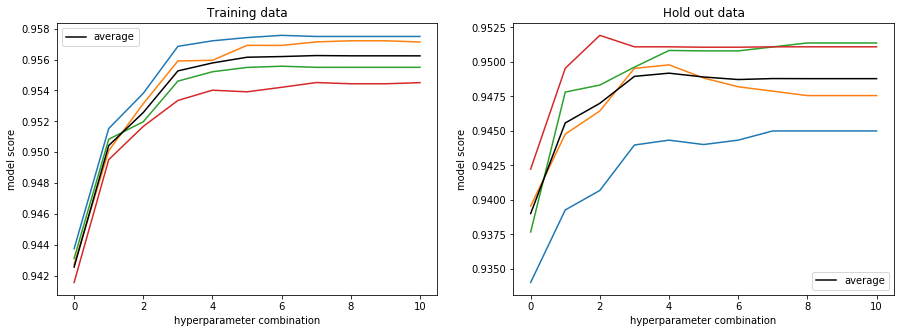

In [29]:
plot_CV_scores(cv_lr)

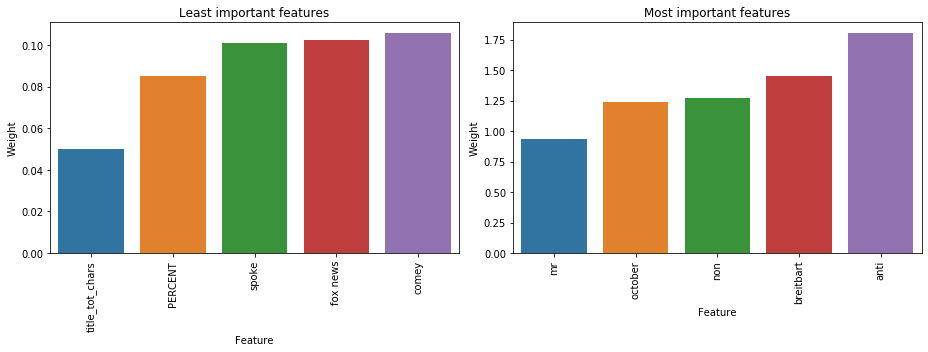

In [23]:
plot_importance(labels, abs(lr_final.coef_[0]))

# Random Forest [Return](#ToC) <a id = 'rf'></a>

Best hyperparameters:
{'max_depth': 30, 'n_estimators': 200}
Confusion matrix results:
[[1934  144]
 [  75 2000]]
Accuracy: 0.9472670358776788
Recall: 0.963855421686747
Precision: 0.9328358208955224
F1: 0.9480919649205973


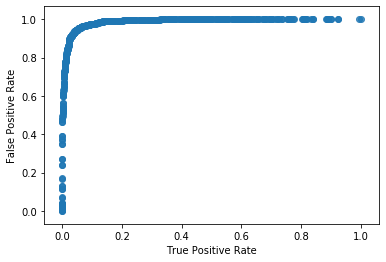

In [32]:
param_grid = {
    'max_depth': [30, 40, 50],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 5,
                              return_train_score = True,
                              scoring = 'f1')
_ = grid_search_rf.fit(X_train, y_train.values)
print('Best hyperparameters:')
print(grid_search_rf.best_params_)
rf_final = RandomForestClassifier(**grid_search_rf.best_params_)
rf_final.fit(X_train, y_train.values)
y_pred_rf = rf_final.predict(X_test)
y_proba_rf = rf_final.predict_proba(X_test)[:, 1]
display_results(y_test, y_pred_rf, y_proba_rf)

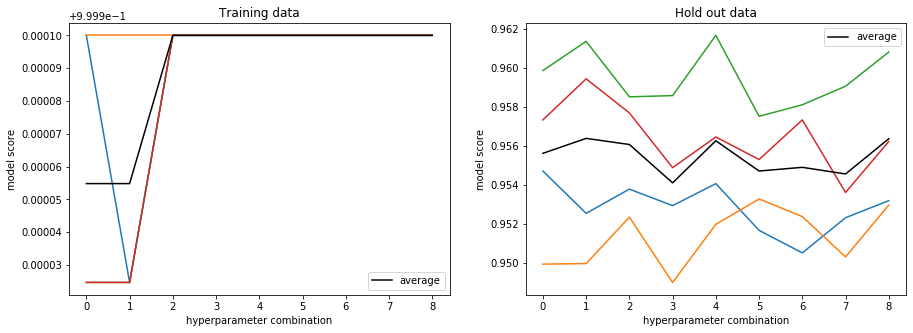

In [36]:
plot_CV_scores(grid_search_rf)

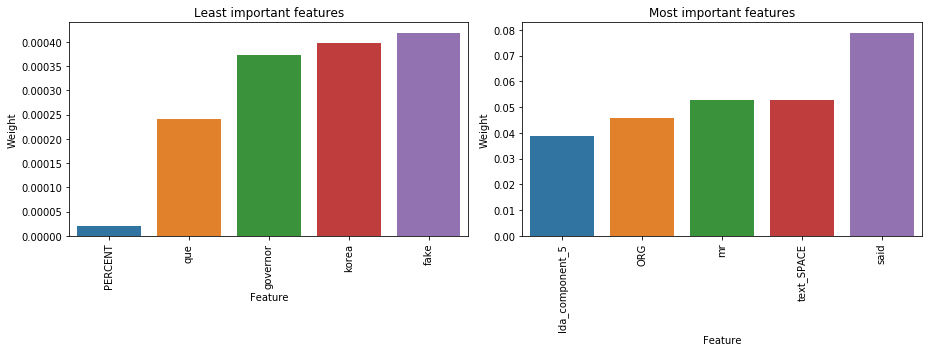

In [37]:
plot_importance(labels, rf_final.feature_importances_)

# XGBoost [Return](#ToC) <a id = 'xgb'></a>

Best hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
Confusion matrix results:
[[1982   96]
 [  88 1987]]
Accuracy: 0.9556946785456296
Recall: 0.9575903614457831
Precision: 0.9539126260201632
F1: 0.9557479557479558


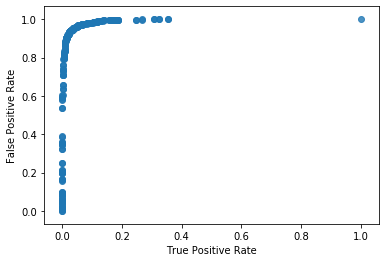

In [35]:
param_grid = {'learning_rate': [0.1],
              'max_depth': [5, 10, 20],
              'n_estimators': [150, 200, 250]
              }
xgr = xgb.XGBClassifier()
grid_search_xgb = GridSearchCV(estimator = xgr, 
                               param_grid = param_grid, 
                               cv = 5,
                              return_train_score = True,
                              scoring = 'f1')
_ = grid_search_xgb.fit(X_train, y_train)
print('Best hyperparameters:')
print(grid_search_xgb.best_params_)
xgb_final = xgb.XGBClassifier(**grid_search_xgb.best_params_)
xgb_final.fit(X_train, y_train)
y_pred_xgb = xgb_final.predict(X_test)
y_proba_xgb = xgb_final.predict_proba(X_test)[:, 1]
display_results(y_test, y_pred_xgb, y_proba_xgb)

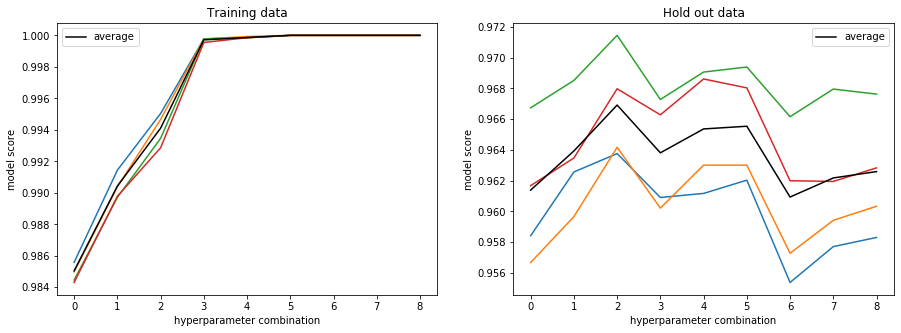

In [38]:
plot_CV_scores(grid_search_xgb)

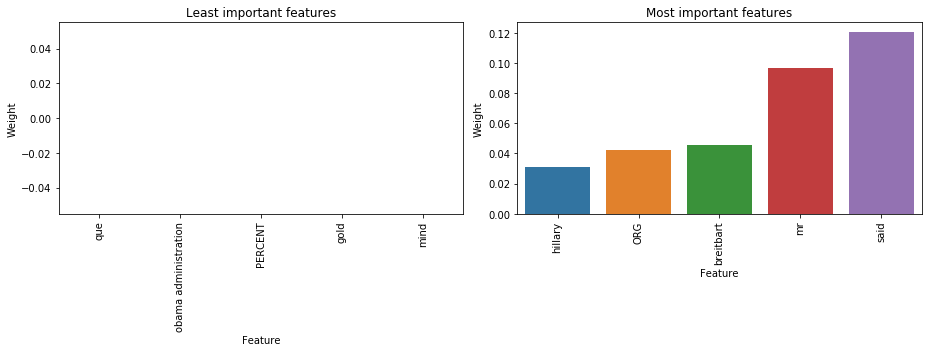

In [39]:
plot_importance(labels, xgb_final.feature_importances_)